# Analysis ver3

This is a derived and cleaned up version of Analysis_ver2, with a pipeline for the first version of the webapp.

In [1]:
%matplotlib inline

In [2]:
cd /home/tobiszuts/insight/project

/media/tobiszuts/Windows/Data/Work/Insight/project


In [4]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data cleaning

Get the data and start processing.

In [5]:
file_load = "Reddit_depression.p"
results = pickle.load( open(file_load, 'rb'))

## Create Features

In [39]:
def PreProcessData(raw_data) :
    """ This processes the post data, and can be used as 
    a template for the upload data.
    """
    import pandas as pd
    
    data_raw = pd.DataFrame(raw_data)
    # some of these columns aren't being used to create features yet
    extract_keys = ['id', 'author', 'score', 'num_comments', 'downs', 'ups', 
                'created_utc', 'title', 'selftext']
    data = data_raw[sorted(extract_keys)].copy()
    
    # remove all rows without any valid text
    data = data[data.selftext.map(len) > 0]
            
    dates = pd.to_datetime(data.created_utc, unit="s")
    data['created_dayofweek'] = dates.dt.dayofweek
    data['created_hour'] = dates.dt.hour
    data['created_month'] = dates.dt.month
    data['created_year'] = dates.dt.year
    cut_off_year = 2011
    data = data[ data.created_year > cut_off_year]
    print('Removing all posts before 2011.')
    
    data['post_char_len'] = data.selftext.apply(lambda x: len(x))
    data['post_num_qs'] = data.selftext.apply(lambda x: x.count('?'))
    data['title_char_len'] = data.title.apply(lambda x: len(x))
    data['title_num_qs'] = data.title.apply(lambda x: x.count('?'))
    
    def CountPostPunctuation(row) :
        # count the number of punctuation in the selftext
        import string
        punc_set = set(string.punctuation)
        num_punc = 0
        for char in row['selftext'] :
            if char in punc_set :
                num_punc += 1
        return num_punc
    def CountTitlePunctuation(row) :
        # count the number of punctuation in the selftext
        import string
        punc_set = set(string.punctuation)
        num_punc = 0
        for char in row['title'] :
            if char in punc_set :
                num_punc += 1
        return num_punc

    data['post_num_punc'] = data.apply(CountPostPunctuation, axis=1)
    data['title_num_punc'] = data.apply(CountTitlePunctuation, axis=1)
    data['post_perc_punc'] = data.post_num_punc / data.post_char_len
    data['title_perc_punc'] = data.title_num_punc / data.title_char_len
    data.post_perc_punc = data.post_perc_punc.fillna(0)
    print('Earliest post = {}'.format(pd.to_datetime(data.created_utc.min(), unit="s")))

    # get rid of columns that aren't needed for the model
    drop_cols = ['created_utc', 'author', 'downs', 'ups', 'score', 'id']
    #print(data.head())
        
    return data.drop(drop_cols, axis=1)

The following function takes about 5 minutes to run on the whole data set, maybe 20 seconds on 20k posts.

In [40]:
data_clean = PreProcessData(results)
print('There are {} posts after processing.'.format(len(data_clean)))
data_clean.head()

Removing all posts before 2011.
Earliest post = 2012-01-01 00:41:48
There are 73724 posts after processing.


,num_comments,selftext,title,created_dayofweek,created_hour,created_month,created_year,post_char_len,post_num_qs,title_char_len,title_num_qs,post_num_punc,title_num_punc,post_perc_punc,title_perc_punc
0,0,"I can't think straight, I can't concentrate, I...",I feel like my brain doesn't work anymore.,4,14,2,2014,747,1,42,0,34,2,0.045515,0.047619
1,0,There is this amazing girl that i've known sin...,She's the girl i was always looking for... But...,4,14,2,2014,789,5,72,0,43,4,0.054499,0.055556
2,1,I've been struggling with depression since hig...,I don't have anyone and I don't know why,4,14,2,2014,771,0,40,0,25,2,0.032425,0.050000
3,0,i burn myself..... i heat up a knife and hold ...,how often do you guys inflict self harm?,4,13,2,2014,337,1,40,1,19,1,0.056380,0.025000
4,0,I’m scared\n Of myself\n ...,All I do is hide,4,12,2,2014,671,0,16,0,0,0,0.000000,0.000000


# NLP pre-processing

Create the corpus from the text post.  Limit to 20,000 to make processing easier.

In [239]:
data_clean = data_clean[:20000]

Int64Index([    0,     1,     2,     3,     4,     5,     7,     8,     9,
               10,
            ...
            21208, 21209, 21210, 21211, 21212, 21213, 21214, 21215, 21216,
            21217],
           dtype='int64', length=20000)

All processing in one function.

In [42]:
from gensim import corpora, models, similarities

def CreateCorpus(raw_text) :
    """ Create a corpus from an array of documents (each document
        a string).  It expects it as a python object, not a pandas
        one.  Returns an array of tokenized texts and the corpus dictionary.
    """
    from gensim import corpora, models, similarities
    from nltk.tokenize import WordPunctTokenizer
    import string
    from nltk.stem.snowball import SnowballStemmer
    from nltk.corpus import stopwords

    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    word_punct_tokenizer = WordPunctTokenizer()
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    
    texts_proc = []
    for text in raw_text :
        words = word_punct_tokenizer.tokenize(text)
        words = [w for w in words if (w not in stop_words)]
        texts_proc.append([stemmer.stem(w.lower()) for w in words 
                                if not all(c in punctuation for c in w)])
        
    # create dictionary
    corpus_dictionary = corpora.Dictionary(texts_proc)
    corpus_dictionary.filter_extremes(no_below=3, no_above=0.5)
    print(corpus_dictionary)
    
    return texts_proc, corpus_dictionary

In [43]:
# takes ~5 minutes to run
posts_raw = list(data_clean.selftext)
titles_raw = list(data_clean.title)
(all_tokenized, all_dictionary) = CreateCorpus(posts_raw + titles_raw)
posts_tokenized = all_tokenized[:len(posts_raw)]
titles_tokenized = all_tokenized[len(posts_raw):]

Dictionary(11384 unique tokens: ['think', 'straight', 'concentr', 'feel', 'like']...)


Previously (with stop words, no stemming, and extra punctuation, and all 90k posts), dictionary had 80k terms.  With all that filtering, it now has 20k terms.  With only 20k posts, it has 11k terms.

In [44]:
posts_vec = [all_dictionary.doc2bow(post) for post in posts_tokenized]
titles_vec = [all_dictionary.doc2bow(post) for post in titles_tokenized]

Create a couple more features.  Note that the word tokenization here is pretty basic, just splitting on white space, and could definitely be improved.

In [46]:
def AddWordFeatures(dataframe, posts_raw, posts_vec, titles_raw, titles_vec) :
    """ Add some word related features to the dataframe.
        Arguments: X_raw is the raw data without any process.  X_vec is the vectorized
        version of that, which has stop words and punctuation removed.
    """
    dataframe_new = dataframe.copy()
    dataframe_new = dataframe_new.assign(post_word_len1 = [len(post.split()) for post in posts_raw] )
    dataframe_new = dataframe_new.assign(post_word_len2 = [len(post) for post in posts_vec] )
    
    dataframe_new = dataframe_new.assign(title_word_len1 = [len(post.split()) for post in titles_raw] )
    dataframe_new = dataframe_new.assign(title_word_len2 = [len(post) for post in titles_vec] )
    return dataframe_new

In [49]:
data_clean = AddWordFeatures(data_clean, posts_raw, posts_vec, titles_raw, titles_vec)

In [50]:
data_clean.head()

,num_comments,selftext,title,created_dayofweek,created_hour,created_month,created_year,post_char_len,post_num_qs,title_char_len,title_num_qs,post_num_punc,title_num_punc,post_perc_punc,title_perc_punc,post_word_len1,post_word_len2,title_word_len1,title_word_len2
0,0,"I can't think straight, I can't concentrate, I...",I feel like my brain doesn't work anymore.,4,14,2,2014,747,1,42,0,34,2,0.045515,0.047619,143,50,8,5
1,0,There is this amazing girl that i've known sin...,She's the girl i was always looking for... But...,4,14,2,2014,789,5,72,0,43,4,0.054499,0.055556,162,63,15,7
2,1,I've been struggling with depression since hig...,I don't have anyone and I don't know why,4,14,2,2014,771,0,40,0,25,2,0.032425,0.050000,149,44,9,2
3,0,i burn myself..... i heat up a knife and hold ...,how often do you guys inflict self harm?,4,13,2,2014,337,1,40,1,19,1,0.056380,0.025000,65,27,8,5
4,0,I’m scared\n Of myself\n ...,All I do is hide,4,12,2,2014,671,0,16,0,0,0,0.000000,0.000000,103,25,5,2


## Latent Semantic Analysis

This is effectively PCA on the tfidf vectors to cluster them.  Use the Gensim implementation.

In [53]:
from gensim.models import lsimodel
num_lsi_topics = 100
print(all_dictionary)

Dictionary(11384 unique tokens: ['think', 'straight', 'concentr', 'feel', 'like']...)


In [55]:
post_lsi = lsimodel.LsiModel(posts_vec, num_topics=num_lsi_topics, id2word=all_dictionary)
title_lsi = lsimodel.LsiModel(titles_vec, num_topics=num_lsi_topics, id2word=all_dictionary)

In [221]:
def ComputeDocumentLSIs(documents, lsi, N, label_base = 'lsi') : 
    " Compute the LSI representation of every document in the corpus"
    baseline = [0 for x in range(N)]
    col_labels = ['{}_{}'.format(label_base, x) for x in range(N)]
    new_features = pd.DataFrame([], columns=col_labels)
    for (x, text) in enumerate(documents) :
        if len(text) > 0:
            lsi_temp = lsi[text]
            if len(lsi_temp) == N :
                temp = [y for (z,y) in lsi_temp]
                new_features.loc[x] = temp
            else :
                #print(x, len(temp))
                new_features.loc[x] = baseline
        else :
            new_features.loc[x] = baseline
    return new_features

The following has a funny issue: the title LSI features sometimes get returned as a vector with fewer dimensions than N.  For N=100, it goes as low as 93, primarily when the number of words, after stemming, is either 1 or 2.

In [222]:
# this takes 85 s for 20k posts and 20 topics, 154 s for 20k and 100
import time
start_time = time.time()

post_lsi_features = ComputeDocumentLSIs(posts_vec, post_lsi, num_lsi_topics, label_base = 'post_lsi')
title_lsi_features = ComputeDocumentLSIs(titles_vec, title_lsi, num_lsi_topics, label_base = 'title_lsi')

print("--- %s seconds ---" % (time.time() - start_time))  
post_lsi_features.head()

--- 81.038747549057 seconds ---


,post_lsi_0,post_lsi_1,post_lsi_2,post_lsi_3,post_lsi_4,post_lsi_5,post_lsi_6,post_lsi_7,post_lsi_8,post_lsi_9,...,post_lsi_90,post_lsi_91,post_lsi_92,post_lsi_93,post_lsi_94,post_lsi_95,post_lsi_96,post_lsi_97,post_lsi_98,post_lsi_99
0,3.828536,0.633567,-1.490526,0.309397,0.148669,-0.246799,-1.016607,-0.834773,-0.186845,-0.209967,...,0.226927,0.574702,0.387737,-1.072824,-0.096625,0.493620,-0.987974,0.330356,-0.070084,0.534049
1,4.362322,0.512692,-1.460036,-1.982631,0.871212,-0.916897,2.330993,-0.057221,-1.021560,-1.260017,...,-0.827410,0.323106,0.003248,0.552172,0.363975,0.020534,-0.016296,-0.122331,-0.772490,-0.571292
2,4.866837,0.810607,1.073454,0.588158,1.392050,-4.053803,0.384133,-0.495249,2.520379,3.844680,...,0.109633,-0.160761,-1.016772,0.555200,0.033806,0.267345,-0.236921,-0.445109,0.216186,0.523627
3,0.789656,0.135739,-0.020395,-0.042441,-0.303137,0.530142,0.244047,0.474679,0.432723,0.126136,...,-0.286686,-0.180194,0.101938,-0.197686,-0.159458,-0.025053,-0.161170,-0.280319,-0.036334,-0.131410
4,5.406624,-2.138297,-6.856583,-2.847832,-0.412536,-1.484465,3.382475,-0.734081,-5.109708,0.511395,...,0.414142,0.095096,-0.683781,-0.088795,0.174772,0.223542,0.404003,0.718277,0.053148,0.311652


Now create the new feature vector.

In [242]:
def AddLSAFeatures(data_old, post_lsi_features, title_lsi_features) :
    """ Add the LSA features to the dataframe, remove the title and post fields.
        Need to reset index values so no rows are dropped.
    """
    data_new = data_old.copy()
    post_lsi_features = post_lsi_features.set_index(data_new.index)
    title_lsi_features = title_lsi_features.set_index(data_new.index)
    data_new = data_new.join(post_lsi_features)
    data_new = data_new.join(title_lsi_features)
    data_new = data_new.drop(['selftext', 'title'], axis=1)
    
    return data_new

In [243]:
data_clean2 = AddLSAFeatures(data_clean, post_lsi_features, title_lsi_features)
print(data_clean2.shape, post_lsi_features.shape)
data_clean2.head()

(20000, 217) (20000, 100)


,num_comments,created_dayofweek,created_hour,created_month,created_year,post_char_len,post_num_qs,title_char_len,title_num_qs,post_num_punc,...,title_lsi_90,title_lsi_91,title_lsi_92,title_lsi_93,title_lsi_94,title_lsi_95,title_lsi_96,title_lsi_97,title_lsi_98,title_lsi_99
0,0,4,14,2,2014,747,1,42,0,34,...,-0.116498,-0.095092,-0.081540,0.104373,-0.003097,-0.080213,0.059581,-0.061159,0.010931,-0.080847
1,0,4,14,2,2014,789,5,72,0,43,...,-0.028816,0.072875,0.049781,0.162898,0.201626,0.041754,0.059803,-0.104414,0.079218,-0.058239
2,1,4,14,2,2014,771,0,40,0,25,...,0.022695,-0.008500,0.007467,-0.003130,-0.058134,0.004793,-0.033829,-0.009283,-0.013911,0.001754
3,0,4,13,2,2014,337,1,40,1,19,...,-0.066376,-0.349864,0.039773,-0.034748,-0.173236,-0.161002,0.124001,0.005649,-0.052677,-0.100002
4,0,4,12,2,2014,671,0,16,0,0,...,0.004772,0.010931,0.007441,-0.000831,0.008094,-0.004701,0.003350,-0.019895,-0.005237,-0.000790


# Classification Model

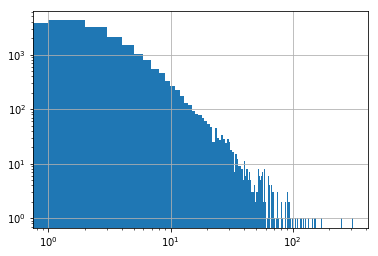

In [561]:
data_clean2.num_comments.hist(bins=311)
plt.yscale('log')
plt.xscale('log')

AttributeError: module 'matplotlib.pyplot' has no attribute 'xticklabel'

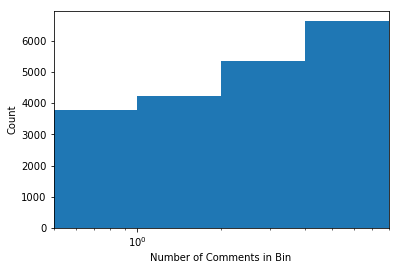

In [574]:
comment_bins = [0, 1, 2, 4, 400]
#comment_bins = [-1, 0.5, 1.5, 3.5, 400]
plt.hist(data_clean2.num_comments, bins=comment_bins)
plt.xlim([0, 20])
plt.xlabel('Number of Comments in Bin')
plt.ylabel('Count')
plt.xscale('log')
plt.xlim([0.5, 8])
plt.xticklabel(['0', '1', '2-3', '4+'])

In [171]:
def BinNumComments(df, bins) :
    """ Bin the number of comments into the specified number of bins
    """
    import pandas as pd
    df_new = df.copy()
    categorized = pd.cut(df_new.num_comments, bins=bins, labels = False, include_lowest = True)
    df_new = df_new.assign(comment_category=categorized)
       
    return df_new.drop('num_comments', axis=1)

In [245]:
data_binned = BinNumComments(data_clean2, comment_bins)
data_binned.head()

,created_dayofweek,created_hour,created_month,created_year,post_char_len,post_num_qs,title_char_len,title_num_qs,post_num_punc,title_num_punc,...,title_lsi_91,title_lsi_92,title_lsi_93,title_lsi_94,title_lsi_95,title_lsi_96,title_lsi_97,title_lsi_98,title_lsi_99,comment_category
0,4,14,2,2014,747,1,42,0,34,2,...,-0.095092,-0.081540,0.104373,-0.003097,-0.080213,0.059581,-0.061159,0.010931,-0.080847,0
1,4,14,2,2014,789,5,72,0,43,4,...,0.072875,0.049781,0.162898,0.201626,0.041754,0.059803,-0.104414,0.079218,-0.058239,0
2,4,14,2,2014,771,0,40,0,25,2,...,-0.008500,0.007467,-0.003130,-0.058134,0.004793,-0.033829,-0.009283,-0.013911,0.001754,0
3,4,13,2,2014,337,1,40,1,19,1,...,-0.349864,0.039773,-0.034748,-0.173236,-0.161002,0.124001,0.005649,-0.052677,-0.100002,0
4,4,12,2,2014,671,0,16,0,0,0,...,0.010931,0.007441,-0.000831,0.008094,-0.004701,0.003350,-0.019895,-0.005237,-0.000790,0


## Train Model

In [270]:
from sklearn import ensemble, linear_model

class BuildClassificationModel() :
    
    def __init__(self, data_x, data_y, model_type = 'randomforest', test_frac = 0.2) :
        from sklearn import ensemble, linear_model
        from sklearn.model_selection import train_test_split
        from sklearn.svm import SVC
        
        (self.train_x, self.test_x, self.train_y, self.test_y) = train_test_split(
                    data_x, data_y, test_size = test_frac)
                
        if model_type == 'randomforest' :
            self.model = ensemble.RandomForestClassifier()
        elif model_type == 'gradientboostingclassifier' :
            self.model = ensemble.GradientBoostingClassifier()
        elif model_type == 'logisticregression' :
            self.model = linear_model.LogisticRegression()
        elif model_type == 'svc' :
            self.model = SVC(kernel='rbf', C=1e3, gamma=0.1)
        else :
            print('Model type "{}" is not defined'.format(model_type))
            return

        print('{} on {} features.  Training on {} rows, validating on {}.'.format(model_type, self.train_x.shape[1], self.train_x.shape[0], self.test_x.shape[0]))
        self.model.fit(self.train_x, self.train_y)
        return
    
    def predict(self) :
        print('Accuracy: %.3f' % self.model.score(self.test_x, self.test_y))            

        
def TestClassificationModels(train_x, train_y, models_to_test, log_flag = False) :
    "Train model on the models supplied in models_to_test"
    models = []
    for model in models_to_test :
        model_temp = BuildClassificationModel(train_x, train_y, model_type = model)
        model_temp.predict()
        models.append(model_temp)
        print()
    return models

In [272]:
models_to_test = ['randomforest', 'gradientboostingclassifier', 'logisticregression', 'svc']
train_x = data_binned.drop('comment_category', axis=1)
train_y = data_binned.comment_category

models = TestClassificationModels(train_x, train_y, models_to_test)

randomforest on 216 features.  Training on 16000 rows, validating on 4000.

randomforest
Accuracy: 0.353
gradientboostingclassifier on 216 features.  Training on 16000 rows, validating on 4000.

gradientboostingclassifier
Accuracy: 0.429
logisticregression on 216 features.  Training on 16000 rows, validating on 4000.

logisticregression
Accuracy: 0.426
svc on 216 features.  Training on 16000 rows, validating on 4000.

svc
Accuracy: 0.412


# Create pipeline for webapp

In [274]:
model_binned_1_logreg = BuildClassificationModel(train_x, train_y, 'logisticregression')
model_binned_1_logreg.predict()

logisticregression on 216 features.  Training on 16000 rows, validating on 4000.
Accuracy: 0.430


In [ ]:
model_binned_1_logreg.

In [580]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(model_binned_1_logreg.test_y, 
         model_binned_1_logreg.model.predict(model_binned_1_logreg.test_x))

In [582]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.87798896  0.00245248  0.00429185  0.11526671]
 [ 0.7983871   0.0016129   0.00322581  0.19677419]
 [ 0.79694019  0.          0.00278164  0.20027816]
 [ 0.71650485  0.          0.00485437  0.27864078]]


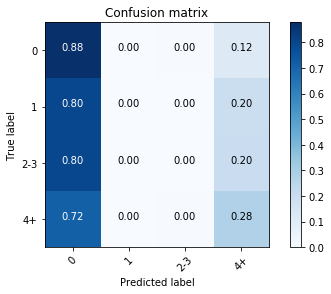

In [586]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2-3', '4+'], normalize=True)

In [275]:
import pickle
pickle.dump(model_binned_1_logreg, open('Model_binned_1_logreg_class.p', 'wb'))
pickle.dump(model_binned_1_logreg.model, open('Model_binned_1_logreg_model.p', 'wb'))

In [276]:
class ProcessingVariables() :
    "Class to easily store all variables needed for processing"
    def __init__(self, num_lsi_topics, post_lsi, title_lsi, dictionary, comment_bins) :
        self.num_lsi_topics = num_lsi_topics
        self.post_lsi = post_lsi
        self.title_lsi = title_lsi
        self.comment_bins = comment_bins
        self.dictionary = dictionary


    def extract_all(self) :
        return (self.num_lsi_topics, self.post_lsi, 
                self.title_lsi, self.dictionary, self.comment_bins)

In [287]:
model_binned_1_processing = ProcessingVariables(num_lsi_topics, 
            post_lsi, title_lsi, all_dictionary, comment_bins)
pickle.dump(model_binned_1_processing, open('Model_binned_1_processing', 'wb'))

In [288]:
test = pickle.load(open('Model_binned_1_processing', 'rb'))
(a, b, c, d, e) = test.extract_all()
for t in (a, b, c, d, e) :
    print(type(t))

<class 'int'>
<class 'gensim.models.lsimodel.LsiModel'>
<class 'gensim.models.lsimodel.LsiModel'>
<class 'gensim.corpora.dictionary.Dictionary'>
<class 'list'>


In [538]:
def SaveProcessingVariables(base_name, num_lsi_topics, post_lsi, title_lsi, dictionary, comment_bins) :
    "function to store all processing variables in separate files"
    
    file_name = '{}_num_lsi_topics.p'.format(base_name)
    pickle.dump(num_lsi_topics, open(file_name, 'wb'))
    
    file_name = '{}_post_lsi.p'.format(base_name)
    pickle.dump(post_lsi, open(file_name, 'wb'))
    
    file_name = '{}_title_lsi.p'.format(base_name)
    pickle.dump(title_lsi, open(file_name, 'wb'))
    
    file_name = '{}_dictionary.p'.format(base_name)
    pickle.dump(dictionary, open(file_name, 'wb'))
    
    file_name = '{}_comment_bins.p'.format(base_name)
    pickle.dump(comment_bins, open(file_name, 'wb'))
    
    return

In [539]:
SaveProcessingVariables('Model_binned_1', num_lsi_topics, post_lsi, title_lsi, all_dictionary, comment_bins)

In [350]:
def LoadParameters(model_file_name = 'Model_binned_1_logreg_model.p', 
                   processing_file_name = 'Model_binned_1_processing') :
    "Load variables needed to process a single post"
    import pickle
    temp = pickle.load(open(processing_file_name, 'rb'))
    (num_lsi_topics, post_lsi, title_lsi, all_dictionary, 
         comment_bins) = temp.extract_all()
    model = pickle.load(open(model_file_name, 'rb'))
    
    return (num_lsi_topics, post_lsi, title_lsi, all_dictionary, 
         comment_bins, model)

print(LoadParameters('Model_binned_1_logreg_model.p', 'Model_binned_1_processing'))

(100, <gensim.models.lsimodel.LsiModel object at 0x7fa627dac0b8>, <gensim.models.lsimodel.LsiModel object at 0x7fa627dac080>, <gensim.corpora.dictionary.Dictionary object at 0x7fa627dacc50>, [0, 1, 2, 4, 400], LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))


In [369]:
def PreProcessData(title, post, post_time) :
    """ This processes user entered data.  All input parameters are strings.
    """
    import pandas as pd
    
    date = time.strptime(s, r"%m/%d/%Y %I:%M:%S %p")
    data = pd.DataFrame({
        'title': title, 
        'selftext': post, 
        'created_dayofweek': date.tm_wday,
        'created_hour': date.tm_hour,
        'created_month': date.tm_mon,
        'created_year': 2014,
        }, index=[0])
        
    data['post_char_len'] = data.selftext.apply(lambda x: len(x))
    data['post_num_qs'] = data.selftext.apply(lambda x: x.count('?'))
    data['title_char_len'] = data.title.apply(lambda x: len(x))
    data['title_num_qs'] = data.title.apply(lambda x: x.count('?'))
    
    def CountPostPunctuation(row) :
        # count the number of punctuation in the selftext
        import string
        punc_set = set(string.punctuation)
        num_punc = 0
        for char in row['selftext'] :
            if char in punc_set :
                num_punc += 1
        return num_punc
    def CountTitlePunctuation(row) :
        # count the number of punctuation in the selftext
        import string
        punc_set = set(string.punctuation)
        num_punc = 0
        for char in row['title'] :
            if char in punc_set :
                num_punc += 1
        return num_punc

    data['post_num_punc'] = data.apply(CountPostPunctuation, axis=1)
    data['title_num_punc'] = data.apply(CountTitlePunctuation, axis=1)
    data['post_perc_punc'] = data.post_num_punc / data.post_char_len
    data['title_perc_punc'] = data.title_num_punc / data.title_char_len
    data.post_perc_punc = data.post_perc_punc.fillna(0)
        
    return data

In [362]:
test = pd.DataFrame({
        'title': test_title, 
        'selftext': test_post
        }, index=[0])

In [484]:
def ProcessText(df, post, title, dictionary, post_lsi, title_lsi) :
    """ Process text fields to create all features.
        Returns an dataframe containing the new features.
    """

    def helper(text, dictionary, lsi) :
        "process just one text"
        #from gensim import corpora, models, similarities
        from nltk.tokenize import WordPunctTokenizer
        import string
        from nltk.stem.snowball import SnowballStemmer
        from nltk.corpus import stopwords

        stop_words = set(stopwords.words('english'))
        punctuation = set(string.punctuation)
        word_punct_tokenizer = WordPunctTokenizer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)

        words = word_punct_tokenizer.tokenize(text)
        words = [w for w in words if (w not in stop_words)]
        text_tokenized = [stemmer.stem(word.lower()) for word in words]
        text_vec = dictionary.doc2bow(text_tokenized)
                
        text_features = lsi[text_vec]
        if len(text_features) == lsi.num_topics :
            text_features = [y for (z,y) in text_features]
        else :
            text_features = [0 for x in range(lsi.num_topics)]
    
        return text_tokenized, text_vec, text_features
    
    (post_tokenized, post_vec, post_features) = helper(post, dictionary, post_lsi) 
    (title_tokenized, title_vec, title_features) = helper(title, dictionary, title_lsi) 
    
    df_new = df.copy()
    df_new = df_new.assign(post_word_len1 = len(post.split()))
    df_new = df_new.assign(post_word_len2 = len(post))
    df_new = df_new.assign(title_word_len1 = len(title.split()))
    df_new = df_new.assign(title_word_len2 = len(title))
    
    post_col_names = ['post_lsi_{}'.format(x) for x in range(len(post_features))]
    post_features = pd.DataFrame(data=[post_features], columns=post_col_names, index=[0])
    df_new = df_new.join(post_features)

    title_col_names = ['title_lsi_{}'.format(x) for x in range(len(title_features))]
    title_features = pd.DataFrame(data=[title_features], columns=title_col_names, index=[0])
    df_new = df_new.join(pd.DataFrame(title_features, index=[0]))
                           
    df_new = df_new.drop(['selftext', 'title'], axis=1)
                           
    def AddLSAFeatures(data_old, post_lsi_features, title_lsi_features) :
        """ Add the LSA features to the dataframe, remove the title and post fields.
            Need to reset index values so no rows are dropped.
        """
        data_new = data_old.copy()
        post_lsi_features = post_lsi_features.set_index(data_new.index)
        title_lsi_features = title_lsi_features.set_index(data_new.index)
        data_new = data_new.join(post_lsi_features)
        data_new = data_new.join(title_lsi_features)
        data_new = data_new.drop(['selftext', 'title'], axis=1)

        return data_new
                           

    def ComputeDocumentLSIs(documents, lsi, N, label_base = 'lsi') : 
        " Compute the LSI representation of every document in the corpus"
        baseline = [0 for x in range(N)]
        col_labels = ['{}_{}'.format(label_base, x) for x in range(N)]
        new_features = pd.DataFrame([], columns=col_labels)
        for (x, text) in enumerate(documents) :
            if len(text) > 0:
                lsi_temp = lsi[text]
                if len(lsi_temp) == N :
                    temp = [y for (z,y) in lsi_temp]
                    new_features.loc[x] = temp
                else :
                    #print(x, len(temp))
                    new_features.loc[x] = baseline
            else :
                new_features.loc[x] = baseline
        return new_features

                           
    return df_new

In [388]:
index = 5
test_title = results[index]['title']
test_post = results[index]['selftext']
test_time = pd.to_datetime(results[index]['created_utc'], unit="s").__str__() + ' AM'

In [487]:
df1 = PreProcessData(test_title, test_post, test_time)
df2 = ProcessText(df1, test_post, test_title, all_dictionary, post_lsi, title_lsi)
df2.head()

,created_dayofweek,created_hour,created_month,created_year,post_char_len,post_num_qs,title_char_len,title_num_qs,post_num_punc,title_num_punc,...,title_lsi_90,title_lsi_91,title_lsi_92,title_lsi_93,title_lsi_94,title_lsi_95,title_lsi_96,title_lsi_97,title_lsi_98,title_lsi_99
0,2,14,9,2014,729,0,30,1,30,1,...,0.011998,0.077903,-0.002321,0.025899,-0.019282,-0.079719,-0.051448,0.092041,0.09908,-0.076621


In [496]:
i = 0
for (x,y) in zip(data_binned.columns, df2.columns) :
    if x != y :
        print('no match!')
    else :
        i += 1
print('Percent matching = {:.2f}%'.format(i/len(df2.columns)*100))

Percent matching = 100.00%


In [348]:
test = pd.to_datetime(test_utc, unit="s").__str__()
test

'2014-02-14 11:53:59'

In [386]:
index

5

In [506]:
def ClassifyPost(title, post, time_stamp) :
    """Takes post information and classifies it according to the model.
    """
    
    (num_lsi_topics, post_lsi, title_lsi, all_dictionary, 
         comment_bins, model) = LoadParameters()
    
    df = PreProcessData(title, post, time_stamp)
    df = ProcessText(df, post, title, all_dictionary, post_lsi, title_lsi)
    
    #print(df.head())
    
    # model.predict(df)
    return model.predict(df)[0]

Now it's just a matter of feeding the information into the function and letting it go!

In [512]:
print(ClassifyPost(test_title, test_post, test_time))

1


In [521]:
data_binned.comment_category.iloc[6]

0

In [532]:
data_x = data_binned.drop('comment_category', axis=1)
for index in range(10) :
    test_title = results[index]['title']
    test_post = results[index]['selftext']
    test_time = pd.to_datetime(results[index]['created_utc'], unit="s").__str__()

    prediction = ClassifyPost(test_title, test_post, test_time)
    raw_prediction = model_binned_1_logreg.model.predict(data_x.iloc[index].values.reshape(1, -1))
    print('{}; model {}, post {}'.format(data_binned.comment_category.iloc[index],
                                         raw_prediction, 
                                         prediction, ))

0; model [0], post 1
0; model [0], post 1
0; model [0], post 1
0; model [0], post 3
0; model [0], post 0
2; model [3], post 1
0; model [0], post 3
0; model [0], post 1
0; model [0], post 3
0; model [0], post 0


In [534]:
model_binned_1_logreg.model.C

1.0